# IY011 Contrastive Learning: Evaluation & Deployment

## Classifying Single Trajectories via Reference Library aka "Metric-Based Few-Shot Learning"
Since the model was pre-trained on synthetic data (where labels were just "File IDs"), it doesn't inherently know what "Wild Type" or "Mutant" means. It only knows similarity.

To use this model for classification, we must build a Reference Library (or Support Set). Think of this as giving the model a "dictionary" to translate its abstract physical understanding into your specific biological labels.

### Why do we need a Reference Library?
1. Translation: The model outputs a feature vector (e.g., [0.5, -0.1, ...]). This vector represents the physics (burst frequency, decay), but it has no label. The Reference Library tells us: "Vectors that look like this are usually Wild Type."

2. Adaptability: You don't need to retrain the neural network for every new experiment. If you discover a new mutant tomorrow, you just add 5 examples of it to the library, and the system instantly learns to recognize it.

``` Python

def pipeline_classify_singles(experimental_data, pre_trained_backbone):
    
    # -------------------------------------------------------
    # PART A: Build the Reference Library (The "Dictionary")
    # -------------------------------------------------------
    # Goal: Map biological labels to specific locations in the model's "Feature Space".
    # We do this ONCE using a few known examples (e.g. 5 shots per class).
    
    reference_library = {}  # Stores { 'WildType': [vector1, vector2...], 'Mutant': [...] }
    
    # 1. Collect Known Data
    # known_classes = {'WildType': [traj_1, traj_2, ...], 'Mutant': [traj_A, traj_B, ...]}
    known_classes = load_few_shot_examples(experimental_data) 
    
    # 2. Embed into Feature Space
    ref_vectors = []
    ref_labels = []
    
    for label, trajectories in known_classes.items():
        for raw_traj in trajectories:
            # A. Preprocess (Log + Scale + Crop)
            # Must match exactly what we did during training!
            clean_traj = preprocess(raw_traj) 
            
            # B. Pass through Backbone (Single Input)
            # The backbone converts the noisy time-series into a clean "Physics Vector"
            # Input: (1, Time, 1) -> Output: (1, 64)
            feature_vector = pre_trained_backbone(clean_traj)
            
            # C. Store in Library
            ref_vectors.append(feature_vector)
            ref_labels.append(label)
            
    # 3. Build the Classifier (The "Map")
    # We can use K-Nearest Neighbors to create decision boundaries around our reference points.
    # "If a new point lands near a WildType vector, it is WildType."
    knn_engine = KNN(k=1)
    knn_engine.fit(ref_vectors, ref_labels)

    # -------------------------------------------------------
    # PART B: Classify Unknowns (The "Deployment")
    # -------------------------------------------------------
    # Now we can classify infinite new "Mystery" trajectories.
    
    def classify_mystery_trajectory(mystery_traj):
        # 1. Process the Mystery Signal
        # We assume it follows the same physics, just unknown class.
        clean_mystery = preprocess(mystery_traj)
        
        # 2. Extract Physics Fingerprint
        # The backbone places this new trajectory onto our map.
        mystery_vector = pre_trained_backbone(clean_mystery)
        
        # 3. Query the Library
        # "Which reference point is closest to this mystery vector?"
        # Distance metric: Euclidean (measures similarity in physics)
        prediction = knn_engine.predict(mystery_vector)
        
        return prediction # Returns "WildType" or "Mutant"

    return classify_mystery_trajectory

# EXPLANATION : Why isn't this redundant? (Why not train a classifier directly?)
    
    1. The Trap: A standard classifier trained on synthetic files effectively "cheats." 
       It memorizes static shortcuts—like "Mean Intensity = 500 usually means File #12." 
       Real biological data has totally different intensity/noise profiles, so those 
       shortcuts break immediately (the "Reality Gap").
    
    2. The Solution: The Siamese task forces the model to ignore those static values.
       By comparing random crops, it learns that "burst shape" is the only reliable 
       feature that stays constant. This "physics" (bursting) is the only thing 
       truly shared between our simulations and the real cells.
    
    3. The Bridge: The model now speaks "Physics", but we need "Biology".
       The Reference Library bridges that gap—it's just a lookup table that says:
       "This specific type of bursting behavior corresponds to Wild Type."

In [13]:
# Load siamese data prep pipeline from modularised code
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from models.siamese_transformer import SiameseTransformer
from training.eval import evaluate_model
from training.train import train_model 
from utils.data_loader import SiameseGroupDataset, siamese_data_prep
import wandb

%load_ext autoreload
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data")
RESULTS_PATH = DATA_ROOT / "IY011_simulation_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
# TRAJ_PATH = [DATA_ROOT / f"mRNA_trajectories_mu{row['mu_target']:.3f}_cv{row['cv_target']:.3f}_tac{row['t_ac_target']:.3f}.csv" for idx, row in df_params.iterrows()] # the trajectories 
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]
# === Dataloader hyperparams & data prep ===
batch_size = 64
num_groups_train=20000  
num_groups_val=num_groups_train // 10
num_groups_test=num_groups_train // 10
num_traj=2
train_loader, val_loader, test_loader, scaler = siamese_data_prep(
    TRAJ_NPZ_PATH,
    batch_size=batch_size,
    num_groups_train=num_groups_train,
    num_groups_val=num_groups_val,
    num_groups_test=num_groups_test,
)
# === Dataloader hyperparams & data prep ===

Files split: 655 Train, 164 Val, 205 Test
Generating 20000 training pairs...


Building negative groups: 100%|██████████| 10000/10000 [00:00<00:00, 21452.21it/s]


Generating validation/test pairs...


Building negative groups: 100%|██████████| 1000/1000 [00:00<00:00, 21246.23it/s]


Building negative groups: 100%|██████████| 1000/1000 [00:00<00:00, 21700.55it/s]


Fitting scaler on Log-Transformed training data...
Applying Log-Scaling to all groups...


In [35]:
# === Model hyperparams ===
input_size = 1
num_classes = 2
d_model=64
nhead=4
num_layers=2
dropout=0.001
use_conv1d=False 

# load the siamese model
model = SiameseTransformer(
    input_size=input_size,   
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dropout=dropout,
    use_conv1d=use_conv1d,
)
siamese_model_path = "IY011_siamese_transformer_model_3.pth"
model.load_state_dict(torch.load(siamese_model_path))

# === Model hyperparams ===

# === Training hyperparams ===
epochs = 100
patience = 10
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

### schedulers ### 
# 1. simple scheduler choice
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
# total_steps = epochs * len(train_loader)
# warmup_steps = int(0.1 * total_steps)   # 10% warmup (good default)
#  (from huggingface)
# from transformers import get_cosine_schedule_with_warmup
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=total_steps,
# ) 

loss_fn = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = 1.0
save_path = None
verbose = True

model.to(device)
# === Training hyperparams ===


SiameseTransformer(
  (backbone): TransformerClassifier(
    (input_proj): Linear(in_features=1, out_features=64, bias=True)
    (pe): PositionalEncoding()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.001, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.001, inplace=False)
          (dropout2): Dropout(p=0.001, inplace=False)
        )
      )
    )
    (dropout): Dropout(p=0.001, inplace=False)
    (head): Linear(in_features=64, out_features=2, bias=True

## Test out model using unseen data (single trajectory inputs)

First, let's generate some unseen data using the julia pipeline

In [36]:
from simulation.mean_cv_t_ac import find_tilda_parameters
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model

def generate_unseen_classes(n_classes=5, n_trajs_per_class=20, seq_len=3000):
    """
    Generates N new 'mystery' datasets with random parameters.
    Returns a list of dictionaries, each representing a unique biological condition.
    """
    print(f"Generating {n_classes} unseen classes...")
    unseen_data = []
    
    # Randomly sample parameters (Mu, CV, Tac)
    # We pick ranges similar to the training data to ensure they are valid biological possibilities
    mus = np.random.uniform(10, 1000, n_classes)
    cvs = np.random.uniform(0.5, 2.0, n_classes)
    tacs = np.random.uniform(5, 50, n_classes)
    
    time_points = np.arange(0, seq_len, 1.0)

    for i in range(n_classes):
        try:
            # 1. Solve for physical parameters
            rho, d, sigma_b, sigma_u = find_tilda_parameters(mus[i], tacs[i], cvs[i])
            
            # 2. Simulate
            params = [{"sigma_b": sigma_b, "sigma_u": sigma_u, "rho": rho, "d": d, "label": 0}]
            df = simulate_telegraph_model(params, time_points, n_trajs_per_class)
            
            # 3. Extract clean array (N_trajs, Time)
            # Assuming format: columns t_0...t_T, rows are trajectories
            # Adjust filtering based on your exact df structure
            trajs = df.drop(columns=['label'], errors='ignore').values
            
            unseen_data.append({
                "class_id": f"Mystery_Class_{i}",
                "parameters": {"mu": mus[i], "cv": cvs[i], "tac": tacs[i]},
                "trajectories": trajs
            })
            print(f"  Generated Class {i}: Mu={mus[i]:.1f}, CV={cvs[i]:.2f}")
            
        except Exception as e:
            print(f"  Skipped a class due to solver error: {e}")
            
    return unseen_data

# === RUN GENERATION ===
unseen_datasets = generate_unseen_classes(n_classes=5, n_trajs_per_class=20)

Generating 5 unseen classes...
Using 12 threads for Julia simulation..
  Generated Class 0: Mu=380.8, CV=0.73
Using 12 threads for Julia simulation..
  Generated Class 1: Mu=951.2, CV=0.59
Using 12 threads for Julia simulation..
  Generated Class 2: Mu=734.7, CV=1.80
Using 12 threads for Julia simulation..
  Generated Class 3: Mu=602.7, CV=1.40
Using 12 threads for Julia simulation..
  Generated Class 4: Mu=164.5, CV=1.56


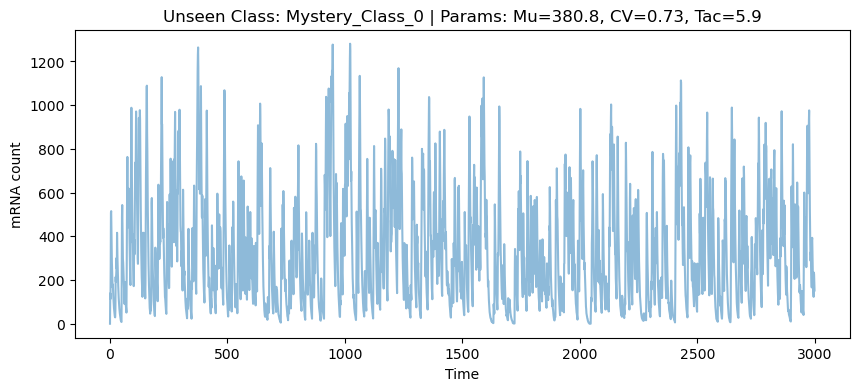

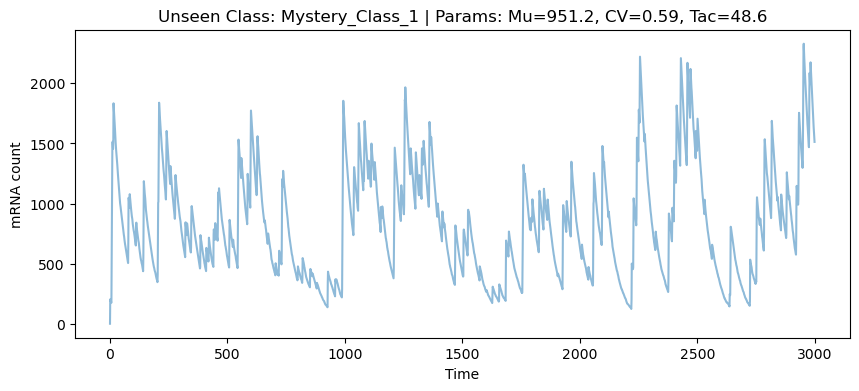

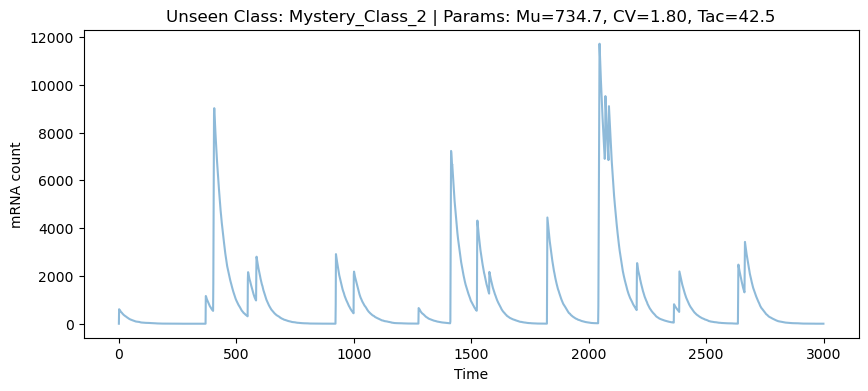

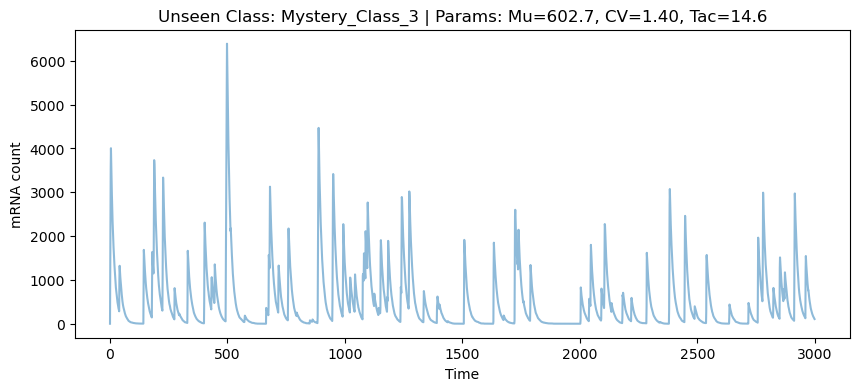

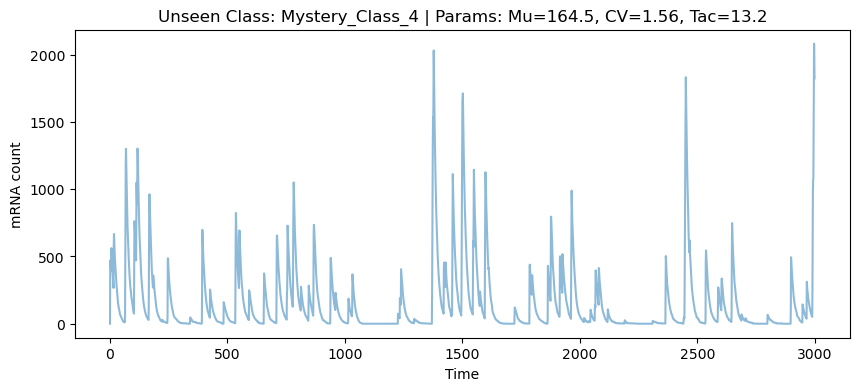

In [37]:
# visualise the unseen classes
for unseen in unseen_datasets:
    trajs = unseen['trajectories']
    plt.figure(figsize=(10,4))
    for i in range(trajs.shape[0]//20):
        plt.plot(trajs[i,:], alpha=0.5)
    plt.title(f"Unseen Class: {unseen['class_id']} | Params: Mu={unseen['parameters']['mu']:.1f}, CV={unseen['parameters']['cv']:.2f}, Tac={unseen['parameters']['tac']:.1f}")
    plt.xlabel("Time")
    plt.ylabel("mRNA count")
    plt.show() 

In [38]:
def build_reference_library(data_list, scaler, crop_len=200, device='cpu', n_shots=5):
    """
    Converts raw data into a clean Reference Library (Tensors).
    Handles NaNs, Infs, and negative values automatically.
    """
    reference_library = {}
    print(f"Building Reference Library ({n_shots}-shot) on {device}...")
    
    for data in data_list:
        class_id = data['class_id']
        # Take first N trajectories
        raw_trajs = data['trajectories'][:n_shots] 
        
        # --- Robust Preprocessing ---
        # 1. Sanitize Input: Replace NaNs with 0, Clip negatives to 0 (for log1p)
        raw_trajs = np.nan_to_num(raw_trajs, nan=0.0, posinf=0.0, neginf=0.0)
        raw_trajs = np.maximum(raw_trajs, 0.0) # Ensure non-negative for log
        
        # 2. Log Transform
        log_trajs = np.log1p(raw_trajs)
        
        # 3. Scaling
        N, T = log_trajs.shape
        # Flatten -> Transform -> Reshape back
        # Note: If scaler has 0 variance for some feature, it might produce NaNs. We sanitize again.
        scaled_flat = scaler.transform(log_trajs.reshape(-1, 1))
        scaled_flat = np.nan_to_num(scaled_flat, nan=0.0) # Sanitize scaler output
        scaled_trajs = scaled_flat.reshape(N, T)
        
        # 4. Cropping / Padding
        processed_list = []
        for i in range(N):
            traj = scaled_trajs[i]
            if len(traj) >= crop_len:
                # Take beginning (or center)
                processed_list.append(traj[:crop_len])
            else:
                # Pad with 0
                pad_len = crop_len - len(traj)
                processed_list.append(np.pad(traj, (0, pad_len), mode='constant', constant_values=0))
                
        # 5. Convert to Tensor & Move to Device
        # Shape: (n_shots, crop_len, 1)
        tensor_stack = torch.tensor(np.array(processed_list), dtype=torch.float32).unsqueeze(-1).to(device)
        reference_library[class_id] = tensor_stack
        
    print(f"✅ Library built for {len(reference_library)} classes.")
    return reference_library

To feed single trajectories into the Siamese model and get a prediction (Class Label), you cannot use the full Siamese architecture (which expects pairs). Instead, you use the Backbone as a feature extractor and a simple Nearest Neighbor (or SVM) Classifier to make the final prediction.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
def setup_inference_engine(model, reference_library, device='cpu'):
    """
    Consumes a Reference Library (Dict of Tensors) and builds the KNN classifier.
    """
    model.eval()
    backbone = model.backbone
    
    ref_features = []
    ref_labels = []
    
    print("Extracting features for Inference Index...")
    
    with torch.no_grad():
        for class_id, ref_tensor in reference_library.items():
            # ref_tensor is already on device and scaled
            
            # 1. Extract Features: (Batch, Time, D) -> (Batch, D)
            embeddings = backbone.encode(ref_tensor).mean(dim=1).cpu().numpy()
            
            # 2. Sanitize Embeddings (Critical check)
            if np.isnan(embeddings).any():
                print(f"⚠️ Warning: NaNs detected in embeddings for class {class_id}. Replacing with 0.")
                embeddings = np.nan_to_num(embeddings, nan=0.0)
            
            # 3. Store
            for emb in embeddings:
                ref_features.append(emb)
                ref_labels.append(class_id)

    # 4. Stack and Shape Check
    X_ref = np.stack(ref_features)
    if X_ref.ndim == 1:
        X_ref = X_ref.reshape(-1, 1)
        
    # 5. Fit KNN
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_ref, np.array(ref_labels))
    
    print(f"✅ Inference Engine Ready. Indexed {len(ref_labels)} samples. Feature Dim: {X_ref.shape[1]}")
    return knn, backbone

In [40]:
def predict_single_trajectory(raw_trajectory, feature_extractor, knn, scaler, crop_len=200, device='cpu'):
    """
    Classifies a SINGLE unknown trajectory with NaN protection.
    """
    # 1. Sanitize Input
    # Handle NaNs/Infs in raw data
    clean_traj = np.nan_to_num(raw_trajectory, nan=0.0, posinf=0.0, neginf=0.0)
    clean_traj = np.maximum(clean_traj, 0.0) # Clip negatives
    
    # 2. Log Transform
    traj_log = np.log1p(clean_traj)
    
    # 3. Handle Length (Crop or Pad)
    if len(traj_log) > crop_len:
        start = (len(traj_log) - crop_len) // 2
        traj_crop = traj_log[start : start + crop_len]
    else:
        pad = crop_len - len(traj_log)
        traj_crop = np.pad(traj_log, (0, pad), mode='constant', constant_values=0)
        
    # 4. Scale
    # Reshape for scaler: (1, 1) if single point, or (N, 1)
    traj_scaled = scaler.transform(traj_crop.reshape(-1, 1)).reshape(crop_len)
    traj_scaled = np.nan_to_num(traj_scaled, nan=0.0) # Sanitize scaler output
    
    # 5. To Tensor
    tensor = torch.tensor(traj_scaled, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    
    # 6. Extract Feature
    with torch.no_grad():
        embedding = feature_extractor.encode(tensor).mean(dim=1).cpu().numpy()
        
    # 7. Sanitize Embedding
    embedding = np.nan_to_num(embedding, nan=0.0)
    
    # Ensure 2D shape for KNN
    if embedding.ndim == 1:
        embedding = embedding.reshape(1, -1)
        
    # 8. Predict
    predicted_class = knn.predict(embedding)[0]
    return predicted_class

In [44]:
# 1. Build the Library (Sanitizes data -> Tensors)
ref_lib = build_reference_library(unseen_datasets, scaler, crop_len=200, device=device)

# 2. Setup Engine (Extracts features -> Fits KNN)
inference_knn, backbone = setup_inference_engine(model, ref_lib, device=device)

# 3. Predict (Sanitizes query -> Predicts)
mystery_traj = unseen_datasets[2]['trajectories'][0] # Example query - should be from Mystery_Class_2
print(f"True class: {unseen_datasets[2]['class_id']}")
pred = predict_single_trajectory(mystery_traj, backbone, inference_knn, scaler, device=device)
print(f"Prediction: {pred}")

Building Reference Library (5-shot) on cuda...
✅ Library built for 5 classes.
Extracting features for Inference Index...
✅ Inference Engine Ready. Indexed 25 samples. Feature Dim: 1
True class: Mystery_Class_2
Prediction: Mystery_Class_2


In [42]:
import numpy as np
from sklearn.metrics import accuracy_score

def get_query_data(unseen_data, n_ref_shots=5):
    """
    Extracts all held-out trajectories and their true labels from the unseen_data.
    The first n_ref_shots are reserved for the reference library.
    """
    query_trajectories = []
    query_labels = []
    
    for data in unseen_data:
        class_id = data['class_id']
        # Use trajectories AFTER the first n_ref_shots (which were used for the library)
        queries = data['trajectories'][n_ref_shots:]
        
        for traj in queries:
            query_trajectories.append(traj)
            query_labels.append(class_id)
            
    return query_trajectories, query_labels

def calculate_few_shot_accuracy(query_trajectories, query_labels, backbone, knn, scaler, crop_len, device):
    """
    Loops through all test queries, uses the predict_single_trajectory function,
    and computes the final accuracy score.
    """
    predicted_labels = []
    
    for traj in query_trajectories:
        # We reuse the exact same prediction logic
        predicted_label = predict_single_trajectory(traj, backbone, knn, scaler, crop_len, device)
        predicted_labels.append(predicted_label)
        
    accuracy = accuracy_score(query_labels, predicted_labels)
    return accuracy

In [43]:
# --- EXECUTION BLOCK (assuming the model, scaler, and inference engine are set up) ---

# Define the constants used for data preparation (should match your setup)
N_SHOTS = 5      # Number of reference trajectories used per class
CROP_LEN = 200   # Match your training crop size
DEVICE = next(model.parameters()).device 

# 1. Extract the held-out test data (Queries)
# The first 5 shots were used for the library, so we test on the remaining ones.
query_trajectories, query_labels = get_query_data(unseen_datasets, n_ref_shots=N_SHOTS)

print(f"Total held-out queries for testing: {len(query_trajectories)}")

# 2. Calculate the final accuracy
final_accuracy = calculate_few_shot_accuracy(
    query_trajectories,
    query_labels,
    backbone, # The feature_extractor
    inference_knn,
    scaler,
    CROP_LEN,
    DEVICE
)

print(f"-------------------------------------------------------")
print(f"✅ FEW-SHOT CLASSIFICATION ACCURACY on Unseen Data: {final_accuracy:.2%}")
print(f"-------------------------------------------------------")

Total held-out queries for testing: 75
-------------------------------------------------------
✅ FEW-SHOT CLASSIFICATION ACCURACY on Unseen Data: 34.67%
-------------------------------------------------------


## Permutation Test

In [46]:
import torch
import numpy as np

def run_siamese_permutation_test(model, test_loader):
    """
    Evaluates Siamese Model on:
    1. Original Pairs (Preserves Temporal Patterns)
    2. Shuffled Pairs (Destroys Temporal Patterns, Preserves Global Stats)
    
    If accuracy drops to ~50% on shuffled data, the model is learning DYNAMICS.
    If accuracy stays high, the model is memorizing STATISTICS (Mean/CV).
    """
    model.eval()
    # Detect device
    device = next(model.parameters()).device
    
    correct_orig = 0
    correct_shuff = 0
    total = 0
    
    print(f"Running Permutation Test on {device}...")
    
    with torch.no_grad():
        for x1, x2, y in test_loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            
            # --- 1. Original Pass ---
            logits_orig = model(x1, x2)
            preds_orig = (logits_orig > 0).float() # Logit > 0 means Prob > 0.5
            correct_orig += (preds_orig == y).sum().item()
            
            # --- 2. Shuffled Pass ---
            # We independently shuffle the time axis (dim=1) for every sample
            # This destroys "burst shape" but keeps "mean intensity" identical
            x1_shuff = x1.clone()
            x2_shuff = x2.clone()
            
            T = x1.shape[1]
            
            for i in range(x1.shape[0]): # Loop over batch
                # Shuffle x1
                idx1 = torch.randperm(T)
                x1_shuff[i] = x1[i, idx1, :]
                
                # Shuffle x2 (different permutation)
                idx2 = torch.randperm(T)
                x2_shuff[i] = x2[i, idx2, :]
            
            logits_shuff = model(x1_shuff, x2_shuff)
            preds_shuff = (logits_shuff > 0).float()
            correct_shuff += (preds_shuff == y).sum().item()
            
            total += y.size(0)
            
    # Calculate Accuracies
    acc_orig = correct_orig / total
    acc_shuff = correct_shuff / total
    
    print(f"------------------------------------------------")
    print(f"Original Pair Accuracy:  {acc_orig:.2%}")
    print(f"Shuffled Pair Accuracy:  {acc_shuff:.2%}")
    print(f"------------------------------------------------")
    
    # Interpretation
    diff = acc_orig - acc_shuff
    if acc_shuff > 0.80:
        print("🚨 VERDICT: MODEL IS RELYING ON STATISTICS.")
        print("It can still match pairs even when time is scrambled.")
        print("It is likely comparing Mean or Variance, not Burst Dynamics.")
    elif acc_shuff < 0.60:
        print("✅ VERDICT: MODEL IS LEARNING DYNAMICS.")
        print("Its performance crashes to near-random when time is scrambled.")
        print("It relies on the temporal shape of the signal.")
    else:
        print("⚠️ VERDICT: HYBRID.")
        print("The model uses a mix of global stats and temporal features.")

# Run it
run_siamese_permutation_test(model, test_loader)

Running Permutation Test on cuda:0...
------------------------------------------------
Original Pair Accuracy:  93.30%
Shuffled Pair Accuracy:  66.90%
------------------------------------------------
⚠️ VERDICT: HYBRID.
The model uses a mix of global stats and temporal features.
